In [237]:
import itertools
import numpy as np
import torch 
from torchvision import datasets, transforms
# from utils import * # get the dataset
from pyhessian import hessian # Hessian computation
# from density_plot import get_esd_plot # ESD plot
# from pytorchcv.model_provider import get_model as ptcv_get_model # model
from swadist.models import ResNet
from swadist.data import get_dataloaders

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 250
plt.rcParams["font.family"] = "serif"

In [238]:
def get_esd_plot(eigenvalues, weights):
    density, grids = density_generate(eigenvalues, weights)
    plt.semilogy(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvalue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    plt.tight_layout()
    plt.title('Distribution of Hessian eigenvalues')

def density_generate(eigenvalues,
                     weights,
                     num_bins=10000,
                     sigma_squared=1e-5,
                     overhead=0.01):

    eigenvalues = np.array(eigenvalues)
    weights = np.array(weights)

    lambda_max = np.mean(np.max(eigenvalues, axis=1), axis=0) + overhead
    lambda_min = np.mean(np.min(eigenvalues, axis=1), axis=0) - overhead

    grids = np.linspace(lambda_min, lambda_max, num=num_bins)
    sigma = sigma_squared * max(1, (lambda_max - lambda_min))

    num_runs = eigenvalues.shape[0]
    density_output = np.zeros((num_runs, num_bins))

    for i in range(num_runs):
        for j in range(num_bins):
            x = grids[j]
            tmp_result = gaussian(eigenvalues[i, :], x, sigma)
            density_output[i, j] = np.sum(tmp_result * weights[i, :])
    density = np.mean(density_output, axis=0)
    normalization = np.sum(density) * (grids[1] - grids[0])
    density = density / normalization
    return density, grids

def gaussian(x, x0, sigma_squared):
    return np.exp(-(x0 - x)**2 /
                  (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

In [239]:
# enable cuda devices
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"

In [240]:
# experiments/CIFAR-10/state_dicts/001/bs512-codist_20220508_143601_rank0.pt
# experiments/CIFAR-10/state_dicts/001/bs512-swa_20220508_140341.pt
# /home/ec2-user/swadist/experiments/CIFAR-10/state_dicts/001/bs512-swadist_20220508_123154_rank0.pt
# experiments/CIFAR-10/state_dicts/001/bs512-sgd_20220508_131727.pt

In [241]:
all_state_dict = torch.load('state_dicts/001/bs512-sgd_20220508_131727.pt')

## Example 2: Power Iteration for NN Hessian

In [242]:
# get the model 
model = ResNet(
    in_kernel_size=3, stack_sizes=[1, 1, 1], n_classes=10, batch_norm=False)
model.load_state_dict(all_state_dict['model_state_dict'])

# change the model to eval mode to disable running stats update
model.eval()

# create loss function
criterion = torch.nn.CrossEntropyLoss()

# get dataset
train_loader, test_loader = get_dataloaders(dataset="cifar10",
                                            batch_size=5000, 
                                            num_workers=4, 
                                            test=False,
                                            pin_memory=False)

# for illustrate, we only use one batch to do the tutorial
for inputs, targets in train_loader:
    break

# we use cuda to make the computation fast
model = model.cuda()
inputs, targets = inputs.cuda(), targets.cuda()

Files already downloaded and verified
Using RandomSampler
Number of training samples: 45000
Number of training batches: 9



In [243]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=True)

In [244]:
# Now let's compute the top eigenvalue. This only takes a few seconds.
# top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
# print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[-1])

In [245]:
# Now let's compute the top 2 eigenavlues and eigenvectors of the Hessian
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
print("The top two eigenvalues of this model are: %.4f %.4f"% (top_eigenvalues[-1],top_eigenvalues[-2]))

The top two eigenvalues of this model are: 241.4143 270.3157


The small difference between this top eigenvalue (195.4954) and the previous one (195.5897) is due to the small number of iterations that we used in Power iteration. You can remove this small difference by increasing the number of iterations for power iteration.

## Example 2.1: Plot Loss Landscape

We can use the Hessian eigenvectors/eigenvalues to analyze the flat/sharpness of the loss landscape of your model, and plot the loss landscape. We will show that this can be more informative than using random directions.

To plot the loss landscape, we first compute the top Hessian eigenvector and then perturb the model parameters along that direction and measure the loss.

In [246]:
# This is a simple function, that will allow us to perturb the model paramters and get the result
def get_params(model_orig, model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

In [247]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

# create a copy of the model
model_perb = ResNet(
    in_kernel_size=3, stack_sizes=[1, 1, 1], n_classes=10, batch_norm=False)
model_perb.load_state_dict(all_state_dict['model_state_dict'])
model_perb.eval()
model_perb = model_perb.cuda()

z = np.zeros((21, 21))
for i in range(21):
    for j in range(21):
        model_perb = get_params(model, model_perb, top_eigenvector[0], lams[i])
        model_perb = get_params(model_perb, model_perb, top_eigenvector[1], lams[j])
        z[j, i] = criterion(model_perb(inputs), targets).item()

In [248]:
xv, yv = np.meshgrid(lams, lams)

Text(0.5, 0, 'Eig 2 perturbation')

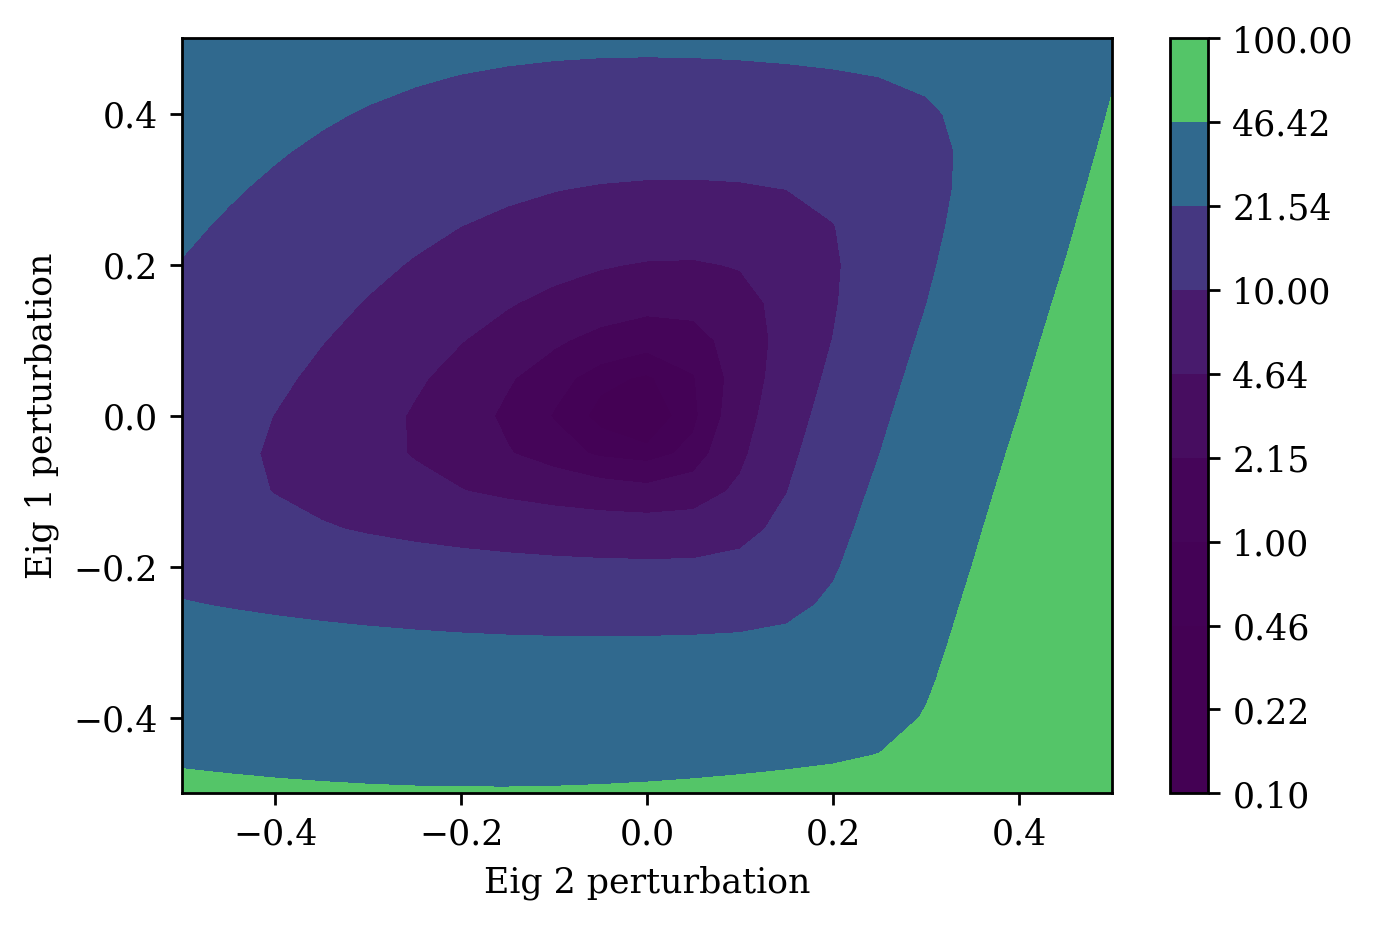

In [258]:
fig, ax = plt.subplots(1, 1)
cs = ax.contourf(xv, yv, z, levels=np.logspace(-1, 2, 10))
cbar = fig.colorbar(cs)
plt.ylabel('Eig 1 perturbation')
plt.xlabel('Eig 2 perturbation')
# plt.title('Loss landscape perturbed based on top 2 Hessian eigenvectors')
# plt.savefig('swadist.png')

Now let's compare this with a loss landscape computed based on perturbing the model parameters along a random direction.

Text(0.5, 1.0, 'Loss landscape perturbed based on a random direction')

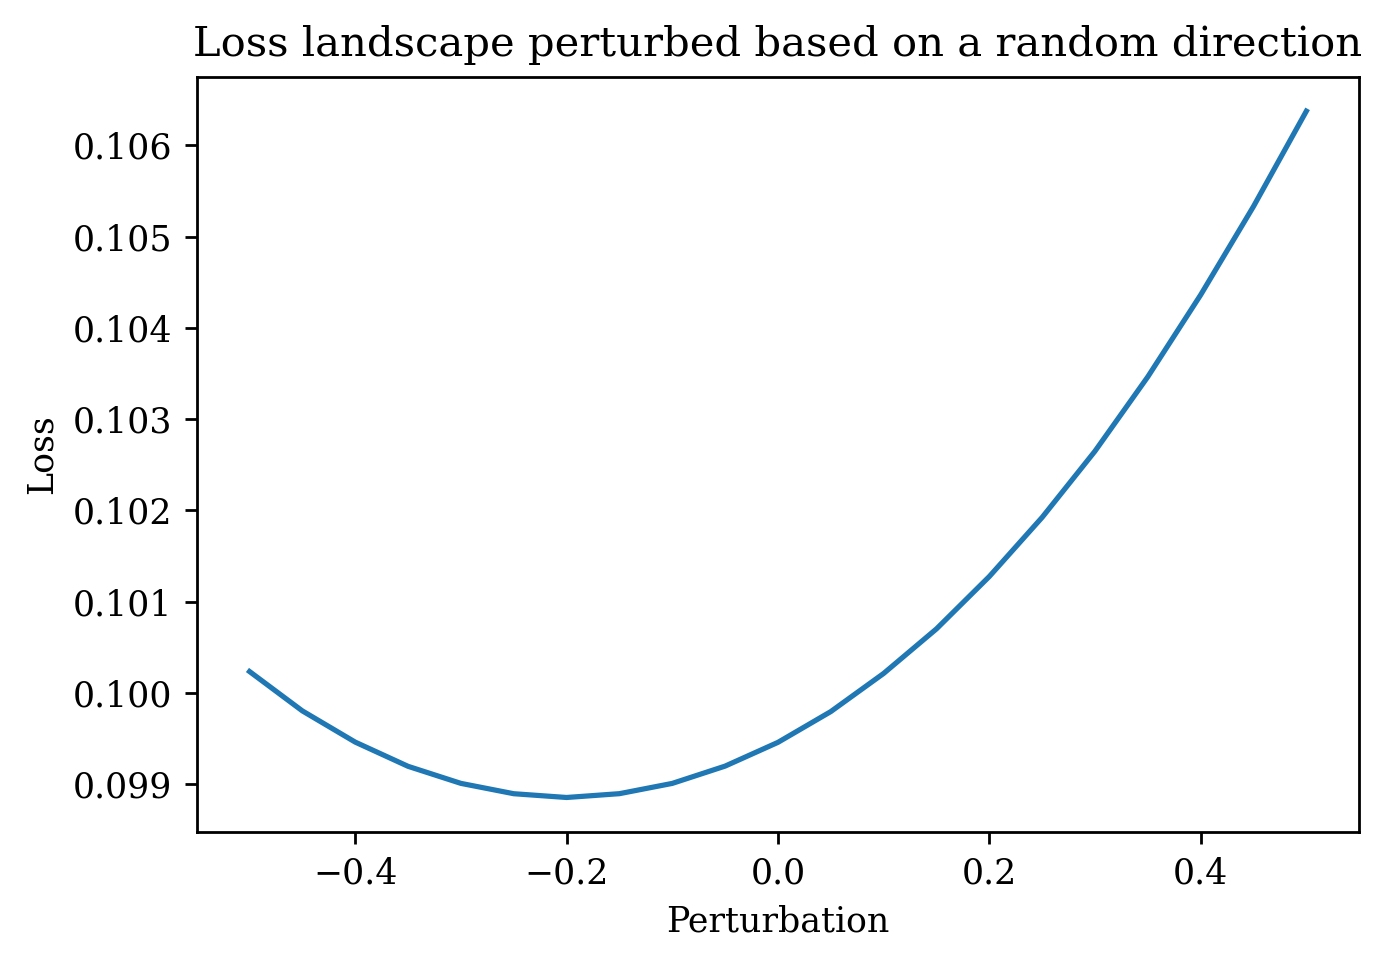

In [250]:
from pyhessian.utils import normalization

# generate random vector to do the loss plot

v = [torch.randn_like(p) for p in model.parameters()]
v = normalization(v)

# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = ResNet(
    in_kernel_size=3, stack_sizes=[1, 1, 1], n_classes=10, batch_norm=False)
model_perb.load_state_dict(all_state_dict['model_state_dict'])
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on a random direction')

Note how different the loss landscape looks. In particular note that there is almost no change in the loss value (see the small scale of the y-axis). This is expected, since for a converged NN, many of the directions are typically degenarate (i.e. they are flat).

We can also use gradient direction to perturb the model. While gradient is better than random vector, but it is not possible to use it to plot 3D loss landscape since you will need more than one direction. However, you can use top 2 Hessian vectors instead for that scenario.

Text(0.5, 1.0, 'Loss landscape perturbed based on gradient direction')

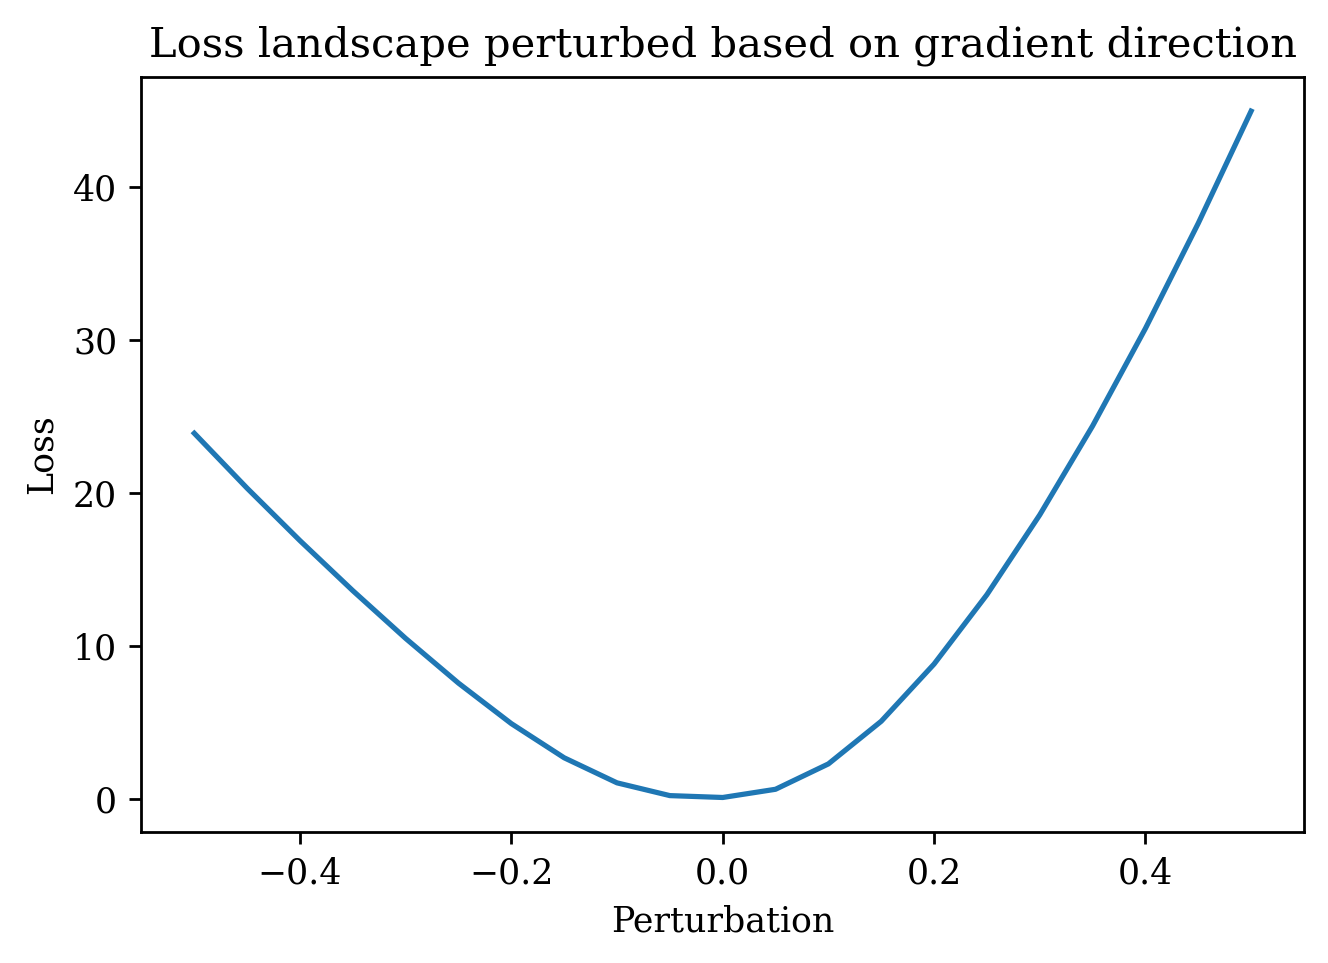

In [251]:
from pyhessian.utils import normalization

# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = ResNet(
    in_kernel_size=3, stack_sizes=[1, 1, 1], n_classes=10, batch_norm=False)
model_perb.load_state_dict(all_state_dict['model_state_dict'])
model_perb.eval()
model_perb = model_perb.cuda()

# generate gradient vector to do the loss plot
loss = criterion(model_perb(inputs), targets)
loss.backward()

v = [p.grad.data for p in model_perb.parameters()]
v = normalization(v)
model_perb.zero_grad()


for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on gradient direction')

## Example 3: Hessian Trace/Diagonal
We can also use randomized linear algebra to compute Hessian trace or approximate the Hessian diagonal with very little computational overhead. Let's first start with a numpy example, and then we will show results for a NN.

Now let's repeate the above for computing the trace and diagonal of Hessian for ResNet20.

In [252]:
# get the model 
model == ResNet(
    in_kernel_size=3, stack_sizes=[1, 1, 1], n_classes=10, batch_norm=False)
model.load_state_dict(all_state_dict['model_state_dict'])
# change the model to eval mode to disable running stats upate
model.eval()

# create loss function
criterion = torch.nn.CrossEntropyLoss()

# for illustrate, we only use one batch to do the tutorial
for inputs, targets in train_loader:
    break

# we use cuda to make the computation fast
model = model.cuda()
inputs, targets = inputs.cuda(), targets.cuda()

In [253]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=True)

In [254]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 3262.5379


We can also get the full eigenvalue spectrum density of Hessian using Stochastic Lancoz algorithm.

In [255]:
density_eigen, density_weight = hessian_comp.density()

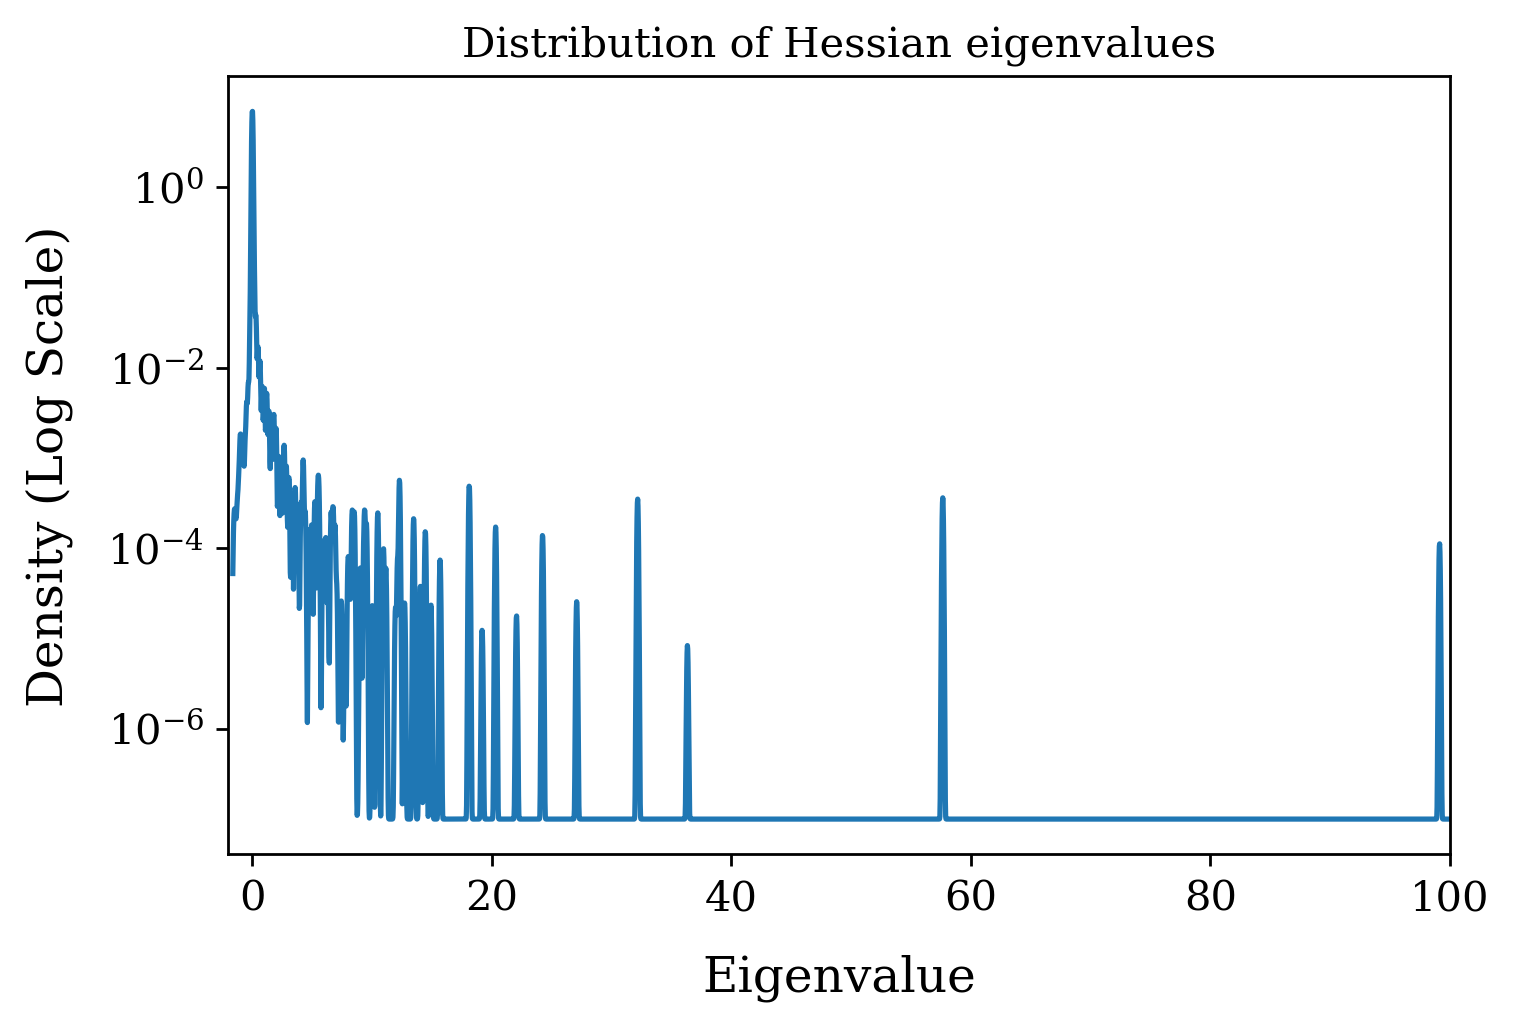

In [256]:
get_esd_plot(density_eigen, density_weight)
plt.xlim(-2, 100)
# plt.savefig('swadist_dwns.png')

The above ESD plot is very interesting and shows that a lot of the eigenvalues of the Hessian are close to zero. This means that a lot of the directions along the loss landscape is almost flat. We expect this based on the loss landscape that we got above when we used a random direction. Another interesting observation is that there are several large Hessian outliers. The other very interesting finding, is that there are a lot of directions with slight negative curvature. This means that we still have not converged to a perfect local minimum that satisfies first and second order optimality conditions.